In [1]:
import scipy.io as sio
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from scipy.stats import norm, multivariate_normal
import matplotlib.pyplot as plt
plt.style.use("seaborn-notebook")
%matplotlib inline
# import matplotlib as mpl
# mpl.rcParams["font.family"] = "DejaVu Sans"
import seaborn as sns
sns.set(font="DejaVu Sans")

In [2]:
dat = sio.loadmat('data/ex8data1.mat')

In [3]:
dat.keys()

dict_keys(['__header__', '__version__', 'Xval', '__globals__', 'yval', 'X'])

In [4]:
def loadMat(matfile):
    dat = sio.loadmat(matfile)
    return map(lambda e: pd.DataFrame(dat.get(e)), ["X", "Xval", "yval"])

In [5]:
#X = pd.DataFrame(dat.get('X'))
#Xval = pd.DataFrame(dat.get('Xval'))
#yval = pd.DataFrame(dat.get('yval'))
X, Xval, yval = loadMat("data/ex8data1.mat")

In [6]:
print(X.describe())
print(Xval.describe())
print(yval.describe())

                0           1
count  307.000000  307.000000
mean    14.112226   14.997711
std      1.355957    1.309707
min      4.752613    4.126232
25%     13.403351   14.361997
50%     14.059507   15.023113
75%     14.675503   15.654394
max     23.339868   24.350407
                0           1
count  307.000000  307.000000
mean    14.019298   15.037747
std      1.589370    1.277235
min      0.307938    5.391413
25%     13.342866   14.377294
50%     14.031070   15.020764
75%     14.708025   15.717998
max     28.541786   23.355973
                0
count  307.000000
mean     0.029316
std      0.168966
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


In [7]:
sum(yval[0] == 0), sum(yval[0] == 1)

(298, 9)

In [8]:
# import matplotlib
# matplotlib.markers?

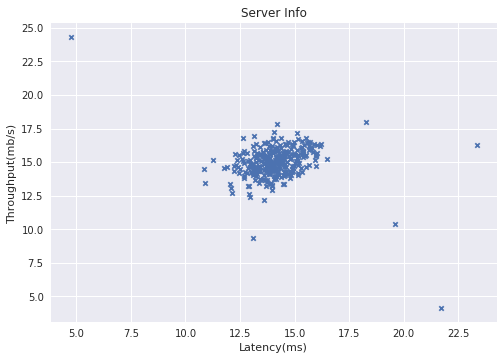

In [9]:
# train data looks like
# plt.figure()
# plt.scatter(X[:, 0], X[:, 1], marker="x")
# plt.xlabel("Latency(ms)")
# plt.ylabel("Through-put(mb/s)")
# plt.title("Server Features")
# plt.show()
ax = X.plot(0, 1, kind="scatter", marker="x",title="Server Info")
ax.set_xlabel("Latency(ms)")
ax.set_ylabel("Throughput(mb/s)")

In [10]:
mu = X.mean()
mu

0    14.112226
1    14.997711
dtype: float64

In [11]:
sd = X.std()
sd

0    1.355957
1    1.309707
dtype: float64

In [12]:
eps = np.linspace(1e-5, 1e-1, 100)
eps[:10]

array([  1.00000000e-05,   1.02000000e-03,   2.03000000e-03,
         3.04000000e-03,   4.05000000e-03,   5.06000000e-03,
         6.07000000e-03,   7.08000000e-03,   8.09000000e-03,
         9.10000000e-03])

In [13]:
Xval.head()

,0,1
0,15.790260,14.921024
1,13.639619,15.329955
2,14.865899,16.473865
3,13.584676,13.989306
4,13.464042,15.635330


In [14]:
y_est = np.exp(norm.logpdf(Xval[0], X.mean()[0], X.std()[0]) + norm.logpdf(Xval[1], X.mean()[1], X.std()[1]))
y_est.shape

(307,)

In [15]:
# calculate the f-score
f1_score(yval[0], [1 if v < eps[0] else 0 for v in y_est], average="binary")

0.7142857142857143

In [16]:
cov = np.matrix(X.cov())
cov

matrix([[ 1.83862041, -0.22786456],
        [-0.22786456,  1.71533273]])

In [17]:
# 各特征相互相乘
def cal_prob(Xval, mu, sd):
    feature_norm = []
    for i in range(len(mu)):
        feature_norm.append(norm.logpdf(Xval.iloc[:, i], mu[i], sd[i]))
    return np.exp(sum(feature_norm))

# 利用多维正太分布模拟
def cal_prob2(Xval, mu, cov):
    return np.exp(multivariate_normal.logpdf(Xval, mu, cov))


def select_best_eps(Xval, yval, mu, sd, eps, func):
    for e in eps:
        # 将各个特征的正太分布相乘
        y_prob = func(Xval, mu, sd)
        y_pred = [1 if v < e else 0 for v in y_prob]
        f1 = f1_score(yval, y_pred, average="binary")
        yield (f1, e)

In [18]:
cal_prob2(Xval, mu, cov)[:5]

array([ 0.04180529,  0.08317355,  0.03731107,  0.05952918,  0.07352085])

In [19]:
fset = select_best_eps(Xval, yval, mu, sd, eps, cal_prob)
best_ = max(fset, key=lambda x: x[0])
print(best_)
fset = select_best_eps(Xval, yval, mu, sd, eps, cal_prob2)
best_ = max(fset, key=lambda x: x[0])
best_

(0.82352941176470595, 0.0010200000000000001)


(0.87500000000000011, 1.0000000000000001e-05)

In [20]:
tr_label = [1 if v < best_[1] else 0 for v in cal_prob(X, mu, sd)]
tr_label[:5]

[0, 0, 0, 0, 0]

In [21]:
X["label"] = ["Normal" if p == 0 else "Problem Server" for p in pd.Series(tr_label)]

Index([0, 1, 'label'], dtype='object')


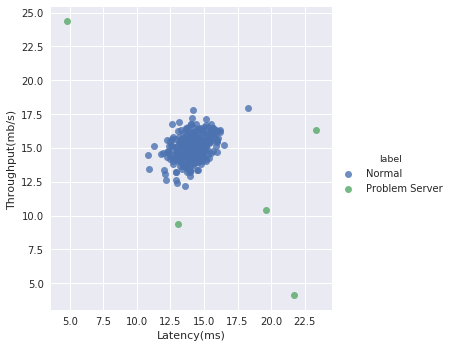

In [22]:
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")
sns.set(font="DejaVu Sans")
# X.plot(0, 1, kind="scatter")
print(X.columns)
X.columns = ["x", "y", "label"]
sns.lmplot(x = "x", y = "y", fit_reg=False, hue="label", data=X)
plt.xlabel("Latency(ms)")
plt.ylabel("Throughput(mb/s)")

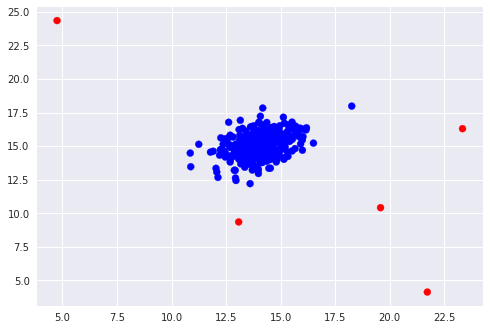

In [23]:
fig, ax = plt.subplots()
colors = {"Normal": "blue", "Problem Server": "red"}
ax.scatter(X["x"], X["y"], c=X["label"].apply(lambda x: colors[x]))
plt.show()

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


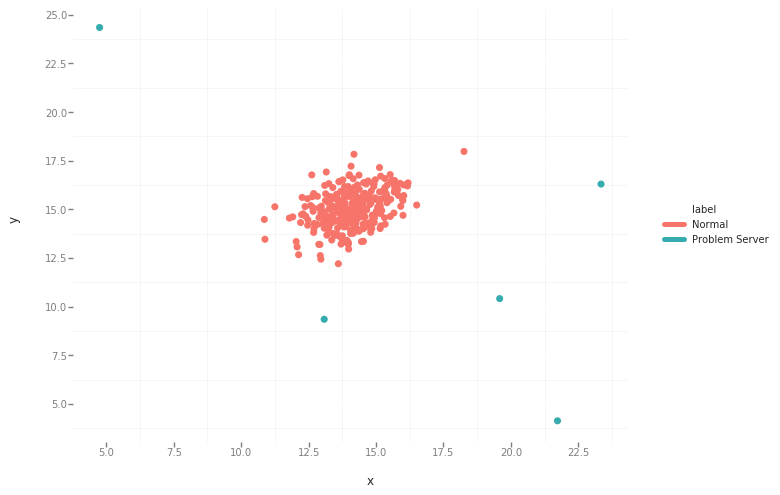

<ggplot: (8777934326697)>

In [24]:
from ggplot import ggplot, aes, geom_point, theme_bw

# only colour, col not work
ggplot(X, aes("x", "y", colour="label")) + \
    geom_point(size=50) + \
    theme_bw()

In [25]:
# 更多特征的数据

X, Xval, yval = loadMat("data/ex8data2.mat")

In [26]:
X.describe()

,0,1,2,3,4,5,6,7,8,9,10
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,4.939400,-9.637268,13.814707,-10.464489,-7.956229,10.199504,-6.019408,7.969829,-6.253182,2.324513,8.473723
std,7.812549,7.297875,7.653368,9.180867,8.082940,9.469136,7.462519,9.340749,5.446001,8.417604,7.110142
min,-17.488978,-38.593613,-9.913776,-35.968341,-35.351822,-19.691088,-32.280955,-23.218312,-22.039903,-23.459247,-20.151703
25%,-0.316875,-14.748531,8.574329,-16.857135,-13.441359,3.845608,-10.927054,1.903339,-10.088911,-3.480037,3.954336
50%,5.307967,-9.713506,13.683700,-10.443133,-8.031732,10.125638,-6.140154,8.256812,-6.277626,2.549715,8.478900
75%,9.988519,-4.861675,18.648459,-4.187347,-2.511060,16.528072,-0.396653,14.180604,-2.540369,7.779696,13.244609
max,28.384866,13.689702,43.322411,16.082439,15.592370,47.131732,25.473844,41.978198,12.090256,26.166271,36.544551


In [27]:
norm.logpdf(np.asarray(X)[:, 1])[:5]

array([ -94.62290389, -180.23656016,  -50.74398161,  -58.33569117,
       -208.76059566])

In [28]:
class ANormalDetector(object):
    
    def __init__(self, model_type="simple"):
        # 没检测属性
        self._mu = None
        self._sd = None
        self._cov = None
        self._model_type = model_type
    
    
    def train(self, X):
        self._mu = X.mean()
        if self._model_type == "simple":
            self._sd = X.std()
        elif self._model_type == "multi":
            self._cov = X.cov()
        else:
            raise("Unknown Model Type.")
    
    def get_param(self):
        return self._mu, self._sd if self._model_type == "simple" else self._cov
    
    def predict_prob(self, Xval):
        if self._model_type == "simple":
            feature_probs = []
            Xval = np.asanyarray(Xval)
            for i in range(len(self._mu)):
                feature_probs.append(norm.logpdf(Xval[:, i], self._mu[i], self._sd[i]))
            probs = np.exp(sum(feature_probs))
            return probs
        elif self._model_type == "multi":
            probs = multivariate_normal.pdf(Xval, self._mu, self._cov)
            return probs
        else:
            raise("Unknown model type!")
    
    def select_best_eps(self, Xval, yval, size=100):
        y_prob = self.predict_prob(Xval)
        step_size = (max(y_prob) - min(y_prob)) / size
        best_f1 = 0
        best_e = 0
        # print(min(y_prob), max(y_prob))
        # print(step_size)
        # 用已经预测好的值进行间隔去epsilo会较为精准，避免随机选取出的参数过于粗略
        for e in np.arange(min(y_prob), max(y_prob), step_size):
            y_label = [1 if p < e else 0 for p in y_prob]
            f1 = f1_score(yval, y_label, average="binary")
            if f1 > best_f1:
                best_f1 = f1
                best_e = e
        return best_f1, best_e
    
Model = ANormalDetector()
Model.train(X)
best_ = Model.select_best_eps(Xval, yval.iloc[:, 0], size=1000)
best_

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.61538461538461542, 1.371660675040733e-18)

In [29]:
# array
sum(Model.predict_prob(X) < best_[1])

117

In [30]:
Model = ANormalDetector(model_type="multi")
Model.train(X)
best_ = Model.select_best_eps(Xval, yval.iloc[:, 0], size=1000)
best_

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.55172413793103448, 1.7464996396712342e-18)

In [31]:
sum(1 if p < best_[1] else 0 for p in Model.predict_prob(X))

122

In [32]:
# array
sum(Model.predict_prob(X) < best_[1])

122

In [33]:
# bool to int
np.asarray((Model.predict_prob(X) < best_[1]) + 0)[:5]

array([0, 0, 0, 0, 0])